## Size effects

The effect that smaller capitalisation stocks tend to outperform larger capitalisation stocks on a risk-adjusted basis has been well-studied. In this notebook, we consider two size metrics
1. A universe wide size efect
2. A sector neutralised size effect

We then consider the strengths of each individual factor and it's predicte strength for 1-month returns.

In [31]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import zscore

load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
psql = create_engine(db_url)

In [32]:
constituents = pd.read_sql(
    """
    select
        ticker, start_date, end_date, sector
    from
        constituents
    """,
    psql
).dropna(subset=['sector'])

constituents['start_date'] = pd.to_datetime(constituents['start_date'])

# keep the row with the latest start_date for each ticker
constituents_latest = (
    constituents
    .sort_values(['ticker', 'start_date'], ascending=[True, False])
    .drop_duplicates(subset='ticker', keep='first')
    .reset_index(drop=True)
)

constituents_latest = constituents[['ticker', 'sector']]

In [33]:
adjusted_monthly = pd.read_sql("""
    select
        *
    from
        adjusted_monthly
    """,
    psql
)
adjusted_monthly['adj_return'] = (
    adjusted_monthly.groupby('ticker')['adj_close']
    .transform(lambda x: np.log(x / x.shift(1)))
)
adjusted_monthly['adj_return_+1'] = (
    adjusted_monthly.groupby('ticker')['adj_return'].shift(-1)
)
adjusted_monthly = adjusted_monthly.dropna()
market_cap = pd.read_sql("""
    select * from fundamentals_monthly where metric = 'marketcap'
""", psql)
returns_and_mc = adjusted_monthly.merge(market_cap, on=['date', 'ticker'])
returns_and_mc = returns_and_mc.merge(constituents_latest, on='ticker')

In [34]:
# larger cap stocks underperform smaller cap stocks, so we should flip the signals
returns_and_mc['size'] = -returns_and_mc.groupby('date')['value'].transform(zscore)
returns_and_mc['size_sector'] = -returns_and_mc.groupby(['date', 'sector'])['value'].transform(zscore)

Consider the 1-month forward rank IC of each factor.

In [ ]:
size_ic = []
size_factors = ['size', 'size_sector']

for date, data in returns_and_mc.groupby('date'):
    for s in size_factors:
        size_ic.append({
            'date': date,
            'ic': data[s].corr(data['adj_return_+1'], method='spearman'),
            'factor': s
        })

size_ic_df = pd.DataFrame(size_ic)
size_ic_df['rolling_ic'] = size_ic_df.groupby('factor')['ic'].transform(lambda x: x.rolling(12 * 5).mean())
size_ic_df = size_ic_df.dropna()

Text(0.5, 1.0, 'The size premium was strong before 2008, re-strengthens ~2012 and has now diminished')

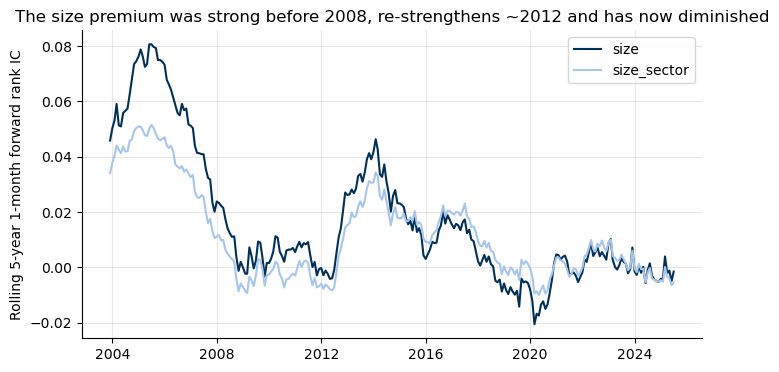

In [42]:
from cycler import cycler

gs_colors = ['#003057', '#A7C6ED', '#D64550', '#7C878E', '#D9D9D6']
plt.rcParams['axes.prop_cycle'] = cycler(color=gs_colors)

plt.figure(figsize=(8, 4))
for s in size_factors:
    s_data = size_ic_df[size_ic_df['factor'] == s]
    plt.plot(s_data['date'], s_data['rolling_ic'], label=s)
sns.despine()
plt.grid(alpha=0.3)
plt.legend()
plt.ylabel('Rolling 5-year 1-month forward rank IC')
plt.title('The size premium was strong before 2008, re-strengthens ~2012 and has now diminished')

We can see that the two factors are clearly highly correlated, and that the universe wide factor is generally better across the history. Hence, we'll just drop the sector-neutralised one.

In [46]:
size_comp = returns_and_mc[['date', 'ticker', 'size']].rename(columns = {'size': 'score'})
size_comp['style'] = 'SIZE'
size_comp['date'] = pd.to_datetime(size_comp['date'])

In [52]:
size_comp.to_sql('factor_composites', psql, if_exists='append', index=False)

557